# Imports and Plot Settings

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from ode_solver import solve_spin_twa, solve_tavis_cummings_twa

W0102 17:11:46.248370   47297 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0102 17:11:46.252011   47215 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.frameon": True,      # Re-enable the legend border
    "legend.framealpha": 1,      # Make the background fully opaque
    "legend.facecolor": "white", # Set the background color to white

    # --- RECOVER TICKS (Add these lines) ---
    "xtick.bottom": True,      # Turn on x-axis ticks
    "ytick.left": True,        # Turn on y-axis ticks
    "xtick.major.size": 6,     # Set length of the ticks
    "ytick.major.size": 6,
    "xtick.minor.size": 3,     # Set length of minor ticks (optional)
    "ytick.minor.size": 3,
    "xtick.direction": "out",   # 'in', 'out', or 'inout' (standard is often 'out', 'in' is common in papers)
    "ytick.direction": "out"
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Open Spin System Test

In [13]:
def hamiltonian(s, args):
    omega, gamma = args
    return omega*s[0]

def spontaneous_emission(s, args):
    omega, gamma = args
    # Note: The factor 0.5 is crucial to match standard Lindblad rate Gamma
    return (jnp.sqrt(gamma) * 0.5) * (s[0] - 1j * s[1])

n_trajectories = int(1e5)
batch_size = int(2e4)
key = jax.random.PRNGKey(42)
t_eval = jnp.linspace(0, 20, int(1e3))

means, vars = [],[]

decays = [0.1, 0.2, 0.5, 1.0, 0.0]

for gamma in decays:
    mean_s, var_s = solve_spin_twa(
    key, n_trajectories, batch_size, t_eval, 
    hamiltonian, [spontaneous_emission], (1.0, gamma)
    )
    means.append(mean_s)
    vars.append(var_s)

means = jnp.array(means)
vars = jnp.array(vars)

Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 5/5 [00:45<00:00,  9.19s/it]


Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 5/5 [00:45<00:00,  9.06s/it]


Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 5/5 [00:46<00:00,  9.28s/it]


Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 5/5 [00:46<00:00,  9.20s/it]


Starting Simulation: 100000 trajectories (Independent Noise)...


100%|██████████| 5/5 [00:46<00:00,  9.26s/it]


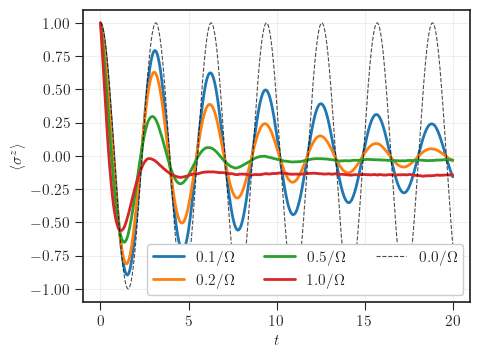

In [14]:
fig, ax = plt.subplots(figsize=(5, 3.8))

for i in range(len(means)-1):
    plt.plot(t_eval, means[i][:,2], label = r'{}/$\Omega$'.format(decays[i]), linewidth = 2.0)

plt.plot(t_eval, means[-1][:,2], label = r'{}/$\Omega$'.format(decays[-1]), color = 'k',
        linestyle = '--', alpha = 0.7, linewidth = 0.8)
plt.ylabel(r'$\langle \sigma^z\rangle$')
plt.xlabel(r'$t$')
plt.grid(alpha = 0.3)
plt.legend(facecolor='white', framealpha=1, ncol = 3)
plt.show()

# Open Tavis-Cummings Test

In [ ]:
omega_ref = 1.0

params_inset = {
    "N": 12,
    "omega_c": 1.0 * omega_ref,      # omega
    "omega_s": 0.5 * omega_ref,      # epsilon = 0.5 * omega
    "kappa":   1.0 * omega_ref,
    "g":       1.7*omega_ref,
    "gamma_d": 0.25*omega_ref,
    "gamma_u": 0.0,
    "init_spin": "up",
    "t_max" : 8*omega_ref
}

n_trajectories = int(1e5) 
batch_size = int(2e4)     # Batch size to fit in memory
key = jax.random.PRNGKey(100) # Reproducibility

t_eval = jnp.linspace(0, params_inset["t_max"], int(1e3))

res = solve_tavis_cummings_twa(
    key,
    n_trajectories,
    batch_size,
    t_eval,
    omega_cavity = params_inset["omega_c"],
    omega_spin = params_inset["omega_s"],
    g = params_inset["g"],
    kappa = params_inset["kappa"],
    gamma_down = params_inset["gamma_d"],
    gamma_up = params_inset["gamma_u"],
    N = params_inset["N"],
    initial_spin_state = params_inset["init_spin"]
)

Solving Tavis-Cummings TWA for N=12 atoms...
Total Trajectories: 100000 | Batches: 5


100%|██████████| 5/5 [01:04<00:00, 12.99s/it]


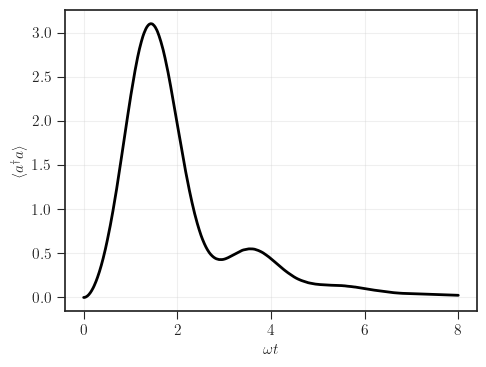

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3.8))

plt.plot(t_eval, res["photon_number"], linewidth=2)
plt.xlabel(r"$\omega t$")
plt.ylabel(r"$\langle a^\dagger a \rangle$")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Open Incoherent Driven Tavis-Cummings Test

In [8]:
omega_ref = 1.0

params_inset = {
    "N": 15,
    "omega_c": 1.0 * omega_ref,      # omega
    "omega_s": 1.0 * omega_ref,      # epsilon = 0.5 * omega
    "kappa":   1.0 * omega_ref,
    "g":       (9/10)*omega_ref,
    "gamma_d": (1/8)*omega_ref,
    "gamma_u": (3/8)*omega_ref ,
    "init_spin": "up",
    "t_max" : 20*omega_ref
}

n_trajectories = int(1e5) 
batch_size = int(2e4)     # Batch size to fit in memory
key = jax.random.PRNGKey(100) # Reproducibility

t_eval = jnp.linspace(0, params_inset["t_max"], int(1e3))

res = solve_tavis_cummings_twa(
    key,
    n_trajectories,
    batch_size,
    t_eval,
    omega_cavity = params_inset["omega_c"],
    omega_spin = params_inset["omega_s"],
    g = params_inset["g"],
    kappa = params_inset["kappa"],
    gamma_down = params_inset["gamma_d"],
    gamma_up = params_inset["gamma_u"],
    N = params_inset["N"],
    initial_spin_state = params_inset["init_spin"]
)

Solving Tavis-Cummings TWA for N=15 atoms...
Total Trajectories: 100000 | Batches: 5


100%|██████████| 5/5 [05:53<00:00, 70.76s/it]


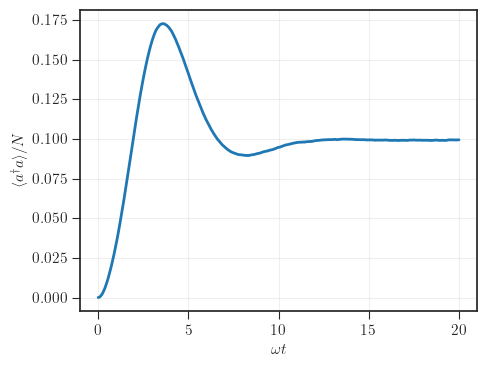

In [9]:
fig, ax = plt.subplots(figsize=(5, 3.8))

plt.plot(t_eval, res["photon_number"]/params_inset['N'], linewidth=2)
plt.xlabel(r"$\omega t$")
plt.ylabel(r"$\langle a^\dagger a \rangle/N$")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()